In [51]:

# Import Required Modules
from flask import Flask, render_template
import pandas as pd
import json
import plotly
import plotly.express as px
import pandas_ta as pta
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from datetime import date
from datetime import timedelta, date
from prophet import Prophet
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import mpld3
import matplotlib.pyplot as plt



# Create Home Page Route
app = Flask(__name__)




df = pd.read_csv("Resources/btcjoin.csv", parse_dates=['date'])
btc_df = yf.Ticker('BTC-USD').history(period='7y',interval='1d',actions=False).reset_index()
btc_df = btc_df.loc[(btc_df['Date'] > '2022-10-25')]
btc_df['Close']=btc_df['Close'].astype("float")
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
btc_df = btc_df.rename(columns={"Close": "price", "Date":"date"})
df = pd.merge(df, btc_df, on=['date', 'price'], how='outer')
df = df.rename(columns={"value": "wallets"})
df = df.drop(columns=['volume','change', 'low', 'high', 'open','Open','High','Low','Unnamed: 0', "wallets", "address", "mined"])
df['200D'] = df['price'].rolling(200).mean()
df['300D'] = df['price'].rolling(300).mean()
df['50D'] = df['price'].rolling(50).mean()
df['7D'] = df['price'].rolling(7).mean()
# df = df.dropna()
df['meanavge'] = (df['200D'] + df['300D'] + df['50D'] )/3
# df = df.drop(columns=['200D','300D', '50D'])
df['meanvalue'] = df["price"] - df["meanavge"]
df['status'] = df['meanvalue'].apply(lambda x: '1' if x > 0 else '0')
df['status']=df['status'].astype("object")
df['price-meanavge']=df['price'] - df['meanavge']
df['move%'] = (df['price-meanavge']/(df['price'] + df['meanavge']))
bins = [-.43, -.18, 0, .18, .43]
group_names = ["Severely Oversold","Neutral Oversold", "Neutral Overbought","Severely Overbought"]
df["Valuation"] = pd.cut(df["move%"], bins, labels=group_names)

k = df['price'].ewm(span=12, adjust=False, min_periods=12).mean()

# Get the 12-day EMA of the closing price
d = df['price'].ewm(span=26, adjust=False, min_periods=26).mean()

# Subtract the 26-day EMA from the 12-Day EMA to get the MACD
macd = k - d

# Get the 9-Day EMA of the MACD for the Trigger line
macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()

# Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
macd_h = macd - macd_s

# Add all of our new values for the MACD to the dataframe
df['macd'] = df.index.map(macd)
df['macd_h'] = df.index.map(macd_h)
df['macd_s'] = df.index.map(macd_s)


df['priceL'] = np.log(df['price'])

df_train = df[['date', 'priceL']]
df_train = df_train.rename(columns = {"date":"ds", "priceL":"y"})

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

start = "2010-09-25"
end = date.today() + timedelta(days=60)
insample = pd.DataFrame(pd.date_range(start,end, periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)


# Buy Zones
fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["red","green","blue","orange"],
                title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
fig.add_trace(go.Scatter(x=prediction['ds'], y=np.exp(prediction['yhat']),
    fill=None,
    mode='lines',
    line_color='lightblue',
    ))
fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_lower']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_upper']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prophet Model + Buy Zones')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.update_layout(height=500, width=1000)
fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")

Buyzones = json.dumps(fig, cls=plotly.utils.PlotlyJSONEncoder)

fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["red","green","blue","orange"],
                title="price")
fig.add_trace(go.Scatter(name="200D", x=df['date'], y=df['200D'], marker = {'color' : 'red'}, legendrank=2))
fig.add_trace(go.Scatter(name="MeanAverage", x=df['date'], y=df['meanavge'], marker = {'color' : 'purple'}, legendrank=2))
fig.add_trace(go.Scatter(name="50D", x=df['date'], y=df['50D'], marker = {'color' : 'blue'}, legendrank=2))
fig.add_trace(go.Scatter(name="300D", x=df['date'], y=df['300D'], marker = {'color' : 'black'}, legendrank=2))

# Moving Averages
fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Moving Averages')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(margin=dict(l=20, r=100, t=70, b=20))
fig.update_layout(height=500, width=1000)
fig.update_layout(showlegend=True)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")

Movingaverages = json.dumps(fig, cls=plotly.utils.PlotlyJSONEncoder)

# MACD

# df.fillna(0, inplace=True)
df_tail = df.tail(360)
df_tail.head()

df_tail['RSI'] = pta.rsi(df['price'], length = 14)

fig = make_subplots(rows=3, cols=1,shared_xaxes=True,vertical_spacing=0.001, row_heights=[0.2, 0.2,0.09])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

# fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
# 					marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
# 			3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=3, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=700, width=1000, title_text="720 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()
	
 

16:25:39 - cmdstanpy - INFO - Chain [1] start processing
16:25:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\16474\AppData\Local\Temp\ipykernel_9656\3123807796.py:165: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:

df['RSI'] = pta.rsi(df['price'], length = 14)

fig = make_subplots(rows=2, cols=1,shared_xaxes=True,vertical_spacing=0.00001, row_heights=[0.2,0.2])

fig.add_trace(
    go.Scatter(name="Price",x=df['date'], y=df['price'],
        marker=dict(color=df['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Scatter(name="RSI",x=df['date'], y=df['RSI'],
    marker=dict(color=df['RSI'], coloraxis="coloraxis3")),
    row=2, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_yaxes(type="log", row=1, col=1)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=700, width=1000, title_text="720 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()

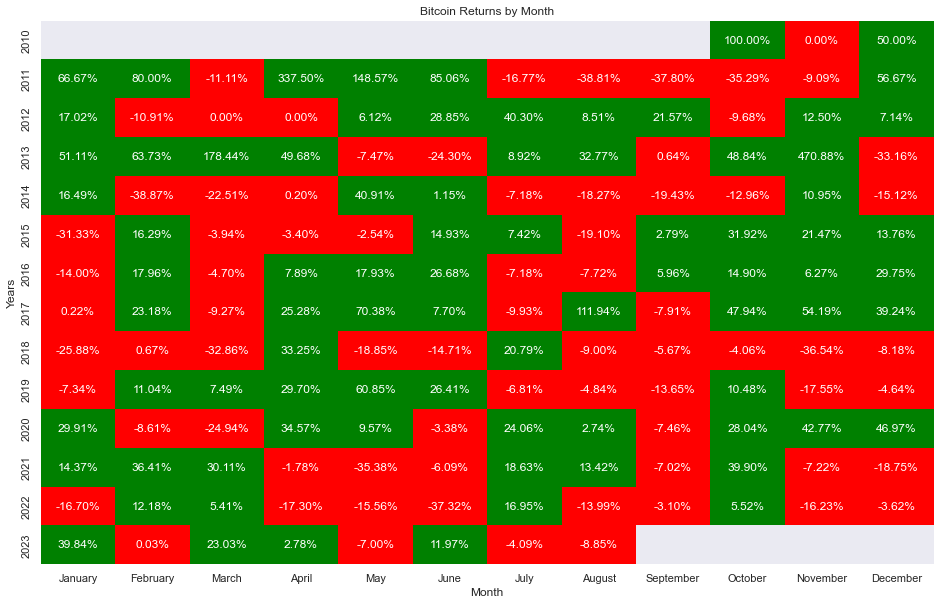

In [62]:
import seaborn as sns
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib import colors


df["month"] = df["date"].dt.strftime('%Y-%m')

# Compute the monthly returns
df_monthly = df.groupby("month")["price"].last().pct_change()

# Convert the resulting Series to a DataFrame
df_returns = df_monthly.to_frame(name="returns")

# Use pivot_table to reshape the data by year and month
df_pivot = df_returns.pivot_table(index=df_returns.index.str.slice(0,4),
                                  columns=df_returns.index.str.slice(5,),
                                  values="returns")

# import pandas as pd
df_pivot.rename(columns={'01': 'January', 
                          '02': 'February', 
                          '03': 'March', 
                          '04': 'April', 
                          '05': 'May', 
                          '06': 'June', 
                          '07': 'July', 
                          '08': 'August', 
                          '09': 'September', 
                          '10': 'October', 
                          '11': 'November', 
                          '12': 'December'}, inplace=True)
# Create a heatmap using Seaborn

heatmap = sns.heatmap(df_pivot, cmap=['red', 'green'],cbar=False, annot=True, fmt=".2%", center=0)
heatmap.tick_params(axis='x', rotation=0)

# Get the current tick locations and labels of the x-axis
x_ticks = heatmap.get_xticks()

# Create a list of all the unique x values in the pivot table
x_values = df_pivot.columns.get_level_values(0)

# Set the label for the x-axis of the heatmap
heatmap.set_xlabel('Month')
heatmap.set_ylabel('Years')
# Set the tick labels for the x-axis
heatmap.set_xticklabels(x_values)

# Add a title to the heatmap
heatmap.set_title("Bitcoin Returns by Month")
# Show the plot
heatmap.figure.savefig("static/heatmap.png")
plt.show()

